# Risk forecasting DNN model

In [51]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional

from sklearn.model_selection import train_test_split

In [53]:
SERIES_PERIOD = '10y'
SERIES_INTERVAL = '1d'

DATA_VARIABLES = 'univariate'
LOOKBACK_WINDOW = 10
TRAIN_TEST_SPLIT = 0.9

EPOCHS = 10
BATCH_SIZE = 32

### Dataset

In [54]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# fetch VIX volatility data
vix = '^VIX'
vix_data = yf.Ticker(vix)
vix_history = vix_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
vix_close = vix_history.Close.loc[vix_history.Close != 0][:-1]

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': sp500_history.Open[:-1] - sp500_history.Open[:-1].min(),
    'high': sp500_history.High[:-1] - sp500_history.High[:-1].min(),
    'low': sp500_history.Low[:-1] - sp500_history.Low[:-1].min(),
    'volume': sp500_history.Volume[:-1] - sp500_history.Volume[:-1].min(),

    'close': close - close.min(),
    'returns': log_returns,
    'vix': vix_close - vix_close.min(),
    'volatility': volatility - volatility.min()
})

# remove NaN values and normalise
X.dropna(inplace=True)
X.open = X.open / X.open.max() 
X.high = X.high / X.high.max() 
X.low = X.low / X.low.max() 
X.volume = X.volume / X.volume.max() 

X.close = X.close / close.max()
X.returns = X.returns / X.returns.max()
X.vix = X.vix / X.vix.max()
X.volatility = X.volatility / X.volatility.max()

X

,open,high,low,volume,close,returns,vix,volatility
Date,,,,,,,,
2012-06-11,0.013582,0.014980,0.011667,0.265216,0.006411,-0.141614,0.196057,0.132339
2012-06-12,0.008955,0.011810,0.011351,0.254252,0.009590,0.129159,0.176071,0.136251
2012-06-13,0.013100,0.012650,0.012458,0.261621,0.007651,-0.078588,0.205710,0.102126
2012-06-14,0.010508,0.014460,0.013492,0.282621,0.010616,0.119940,0.170496,0.113723
2012-06-15,0.014566,0.017186,0.017775,0.365347,0.013480,0.114679,0.162746,0.117266
...,...,...,...,...,...,...,...,...
2022-05-26,0.767513,0.789744,0.773592,0.314400,0.579511,0.219530,0.249626,0.122096
2022-05-27,0.793835,0.813315,0.800014,0.267885,0.600443,0.272527,0.225425,0.132580
2022-05-31,0.814721,0.816101,0.807827,0.456973,0.595003,-0.070182,0.231815,0.152856


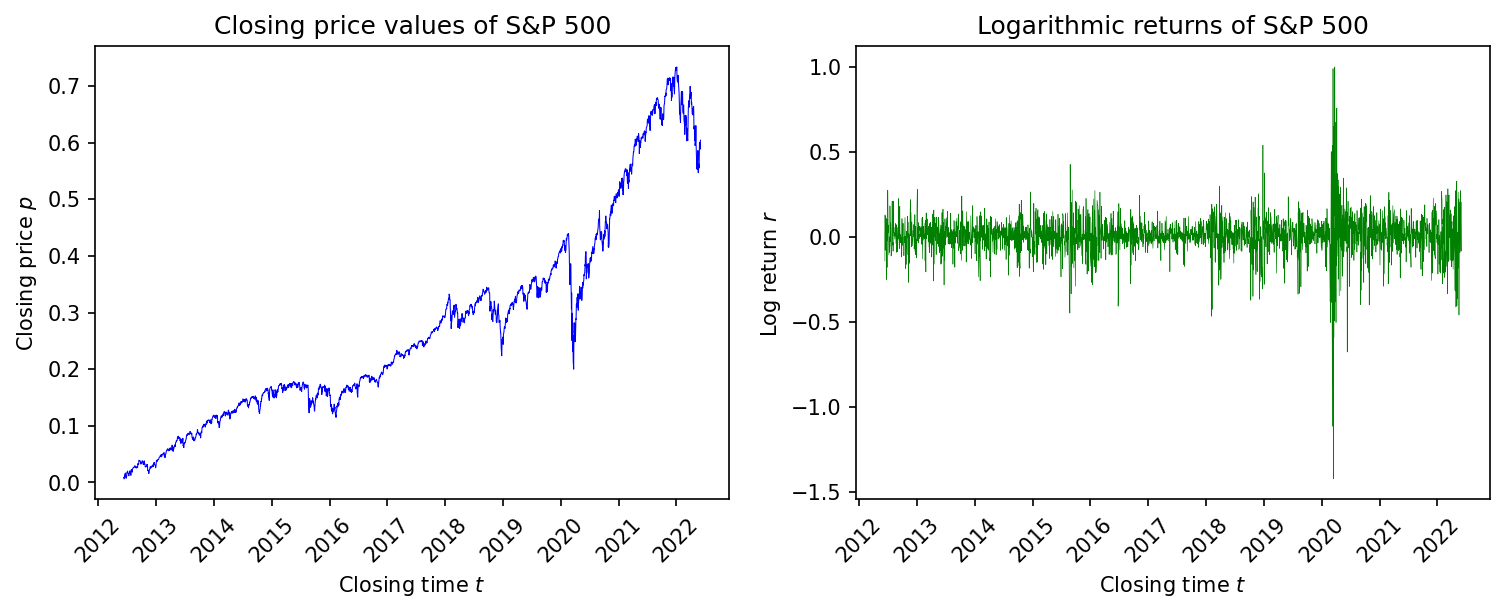

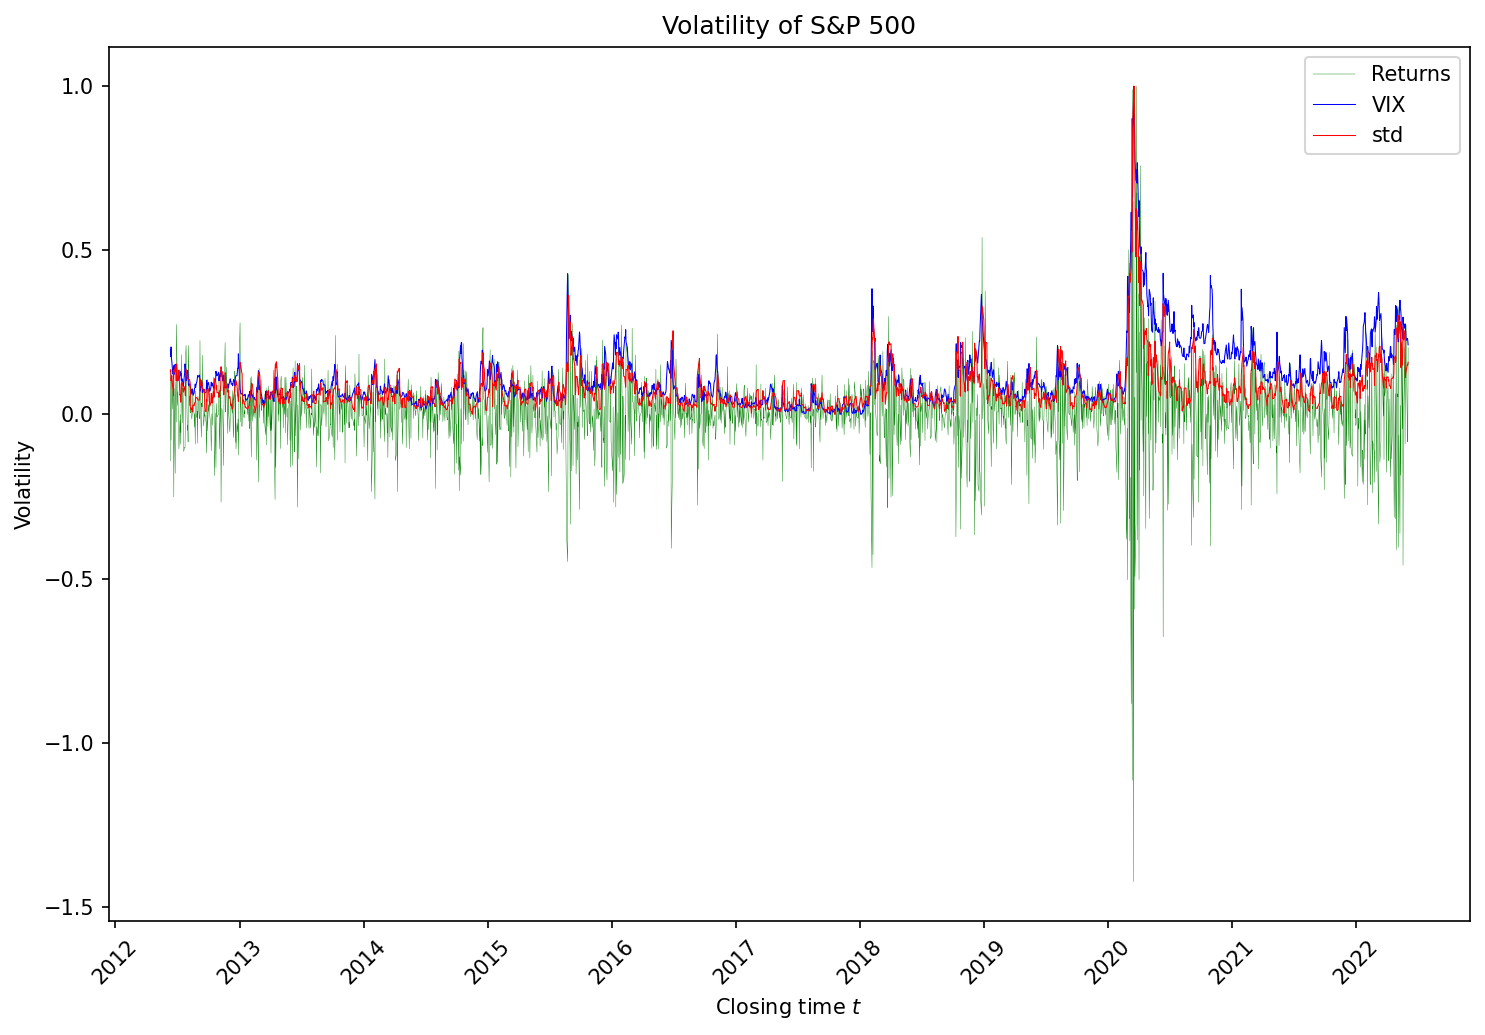

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.5, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.3, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
ax.plot(X.returns, linewidth=0.2, color='g', label='Returns')
ax.plot(X.vix, linewidth=0.5, color='b', label='VIX')
ax.plot(X.volatility, linewidth=0.5, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [56]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the VIX value that comes at the next timestep after this series
X_data = []
y_data = []

if DATA_VARIABLES == 'univariate':

    print("Univariate data")
    for i in range(X.vix.shape[0] - LOOKBACK_WINDOW):
        X_data.append(X.vix[i: i + LOOKBACK_WINDOW])
        y_data.append(X.vix[i + LOOKBACK_WINDOW])

    # convert X to numpy
    X_data = np.array(X_data)
    X_data = np.expand_dims(X_data, 2)

elif DATA_VARIABLES == 'multivariate':

    print("Multivariate data")
    for i in range(X.shape[0] - LOOKBACK_WINDOW):
        X_data.append((
            X.open[i: i + LOOKBACK_WINDOW],
            X.high[i: i + LOOKBACK_WINDOW],
            X.low[i: i + LOOKBACK_WINDOW],
            X.volume[i: i + LOOKBACK_WINDOW],
            X.close[i: i + LOOKBACK_WINDOW],
            X.returns[i: i + LOOKBACK_WINDOW],
            X.vix[i: i + LOOKBACK_WINDOW],
            X.volatility[i: i + LOOKBACK_WINDOW],
        ))
        y_data.append(X.vix[i + LOOKBACK_WINDOW])

    # convert X to numpy
    X_data = np.array(X_data)

else:
    exit(1)

# convert y to numpy
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, 1)

print(X_data.shape, y_data.shape)

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=(1 - TRAIN_TEST_SPLIT), shuffle=False)

# train_test_split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

# X_test = X_data[train_test_split:]
# y_test = y_data[train_test_split:]

# X_train_raw = X_data[:train_test_split]
# y_train_raw = y_data[:train_test_split]

# # shuffle X and y in unision
# X_train = np.empty(X_train_raw.shape, dtype=X_train_raw.dtype)
# y_train = np.empty(y_train_raw.shape, dtype=y_train_raw.dtype)
# perm = np.random.permutation(X_train_raw.shape[0])

# for i_old, i_new in enumerate(perm):
#     X_train[i_new] = X_train_raw[i_old]
#     y_train[i_new] = y_train_raw[i_old]

print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

Univariate data
(2502, 10, 1) (2502, 1)
(2251, 10, 1) (2251, 1) 
 (251, 10, 1) (251, 1)


In [57]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(1, activation='linear')
])

gru_model = Sequential([
    GRU(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    GRU(256, activation='tanh'),
    Dense(1, activation='linear')
])

lstm_model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(256, activation='tanh'),
    Dense(1, activation='linear')
])

bidir_model = Sequential([
    Bidirectional(
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:]))
    ),
    Bidirectional(
        LSTM(256, activation='tanh')
    ),
    Dense(1, activation='linear')
])

rnn_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
gru_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
lstm_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
bidir_model.compile(loss='mae', optimizer='adam', metrics=['mse'])

In [58]:
rnn_history = rnn_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
gru_history = gru_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
lstm_history = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
bidir_history = bidir_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
71/71 [==============================] - 3s 19ms/step - loss: 0.0540 - mse: 0.0303
Epoch 2/10
71/71 [==============================] - 1s 19ms/step - loss: 0.0154 - mse: 7.2973e-04
Epoch 3/10
71/71 [==============================] - 1s 19ms/step - loss: 0.0159 - mse: 7.6996e-04
Epoch 4/10
71/71 [==============================] - 1s 19ms/step - loss: 0.0146 - mse: 6.6222e-04
Epoch 5/10
71/71 [==============================] - 1s 19ms/step - loss: 0.0144 - mse: 6.6814e-04
Epoch 6/10
71/71 [==============================] - 1s 19ms/step - loss: 0.0145 - mse: 7.0327e-04
Epoch 7/10
71/71 [==============================] - 1s 19ms/step - loss: 0.0151 - mse: 6.7997e-04
Epoch 8/10
71/71 [==============================] - 1s 19ms/step - loss: 0.0146 - mse: 6.8982e-04
Epoch 9/10
71/71 [==============================] - 1s 19ms/step - loss: 0.0147 - mse: 6.8733e-04
Epoch 10/10
71/71 [==============================] - 1s 19ms/step - loss: 0.0154 - mse: 7.1850e-04
Epoch 1/10
71/71 [=====

 - RNN: 
	 mae = 0.01916; mse = 0.00079; msle = 0.00054; mape = 10.70749%
 - GRU: 
	 mae = 0.01961; mse = 0.00083; msle = 0.00057; mape = 10.94535%
 - LSTM: 
	 mae = 0.01953; mse = 0.00084; msle = 0.00057; mape = 10.86290%
 - Bidirectional LSTM: 
	 mae = 0.01964; mse = 0.00073; msle = 0.00050; mape = 11.34151%


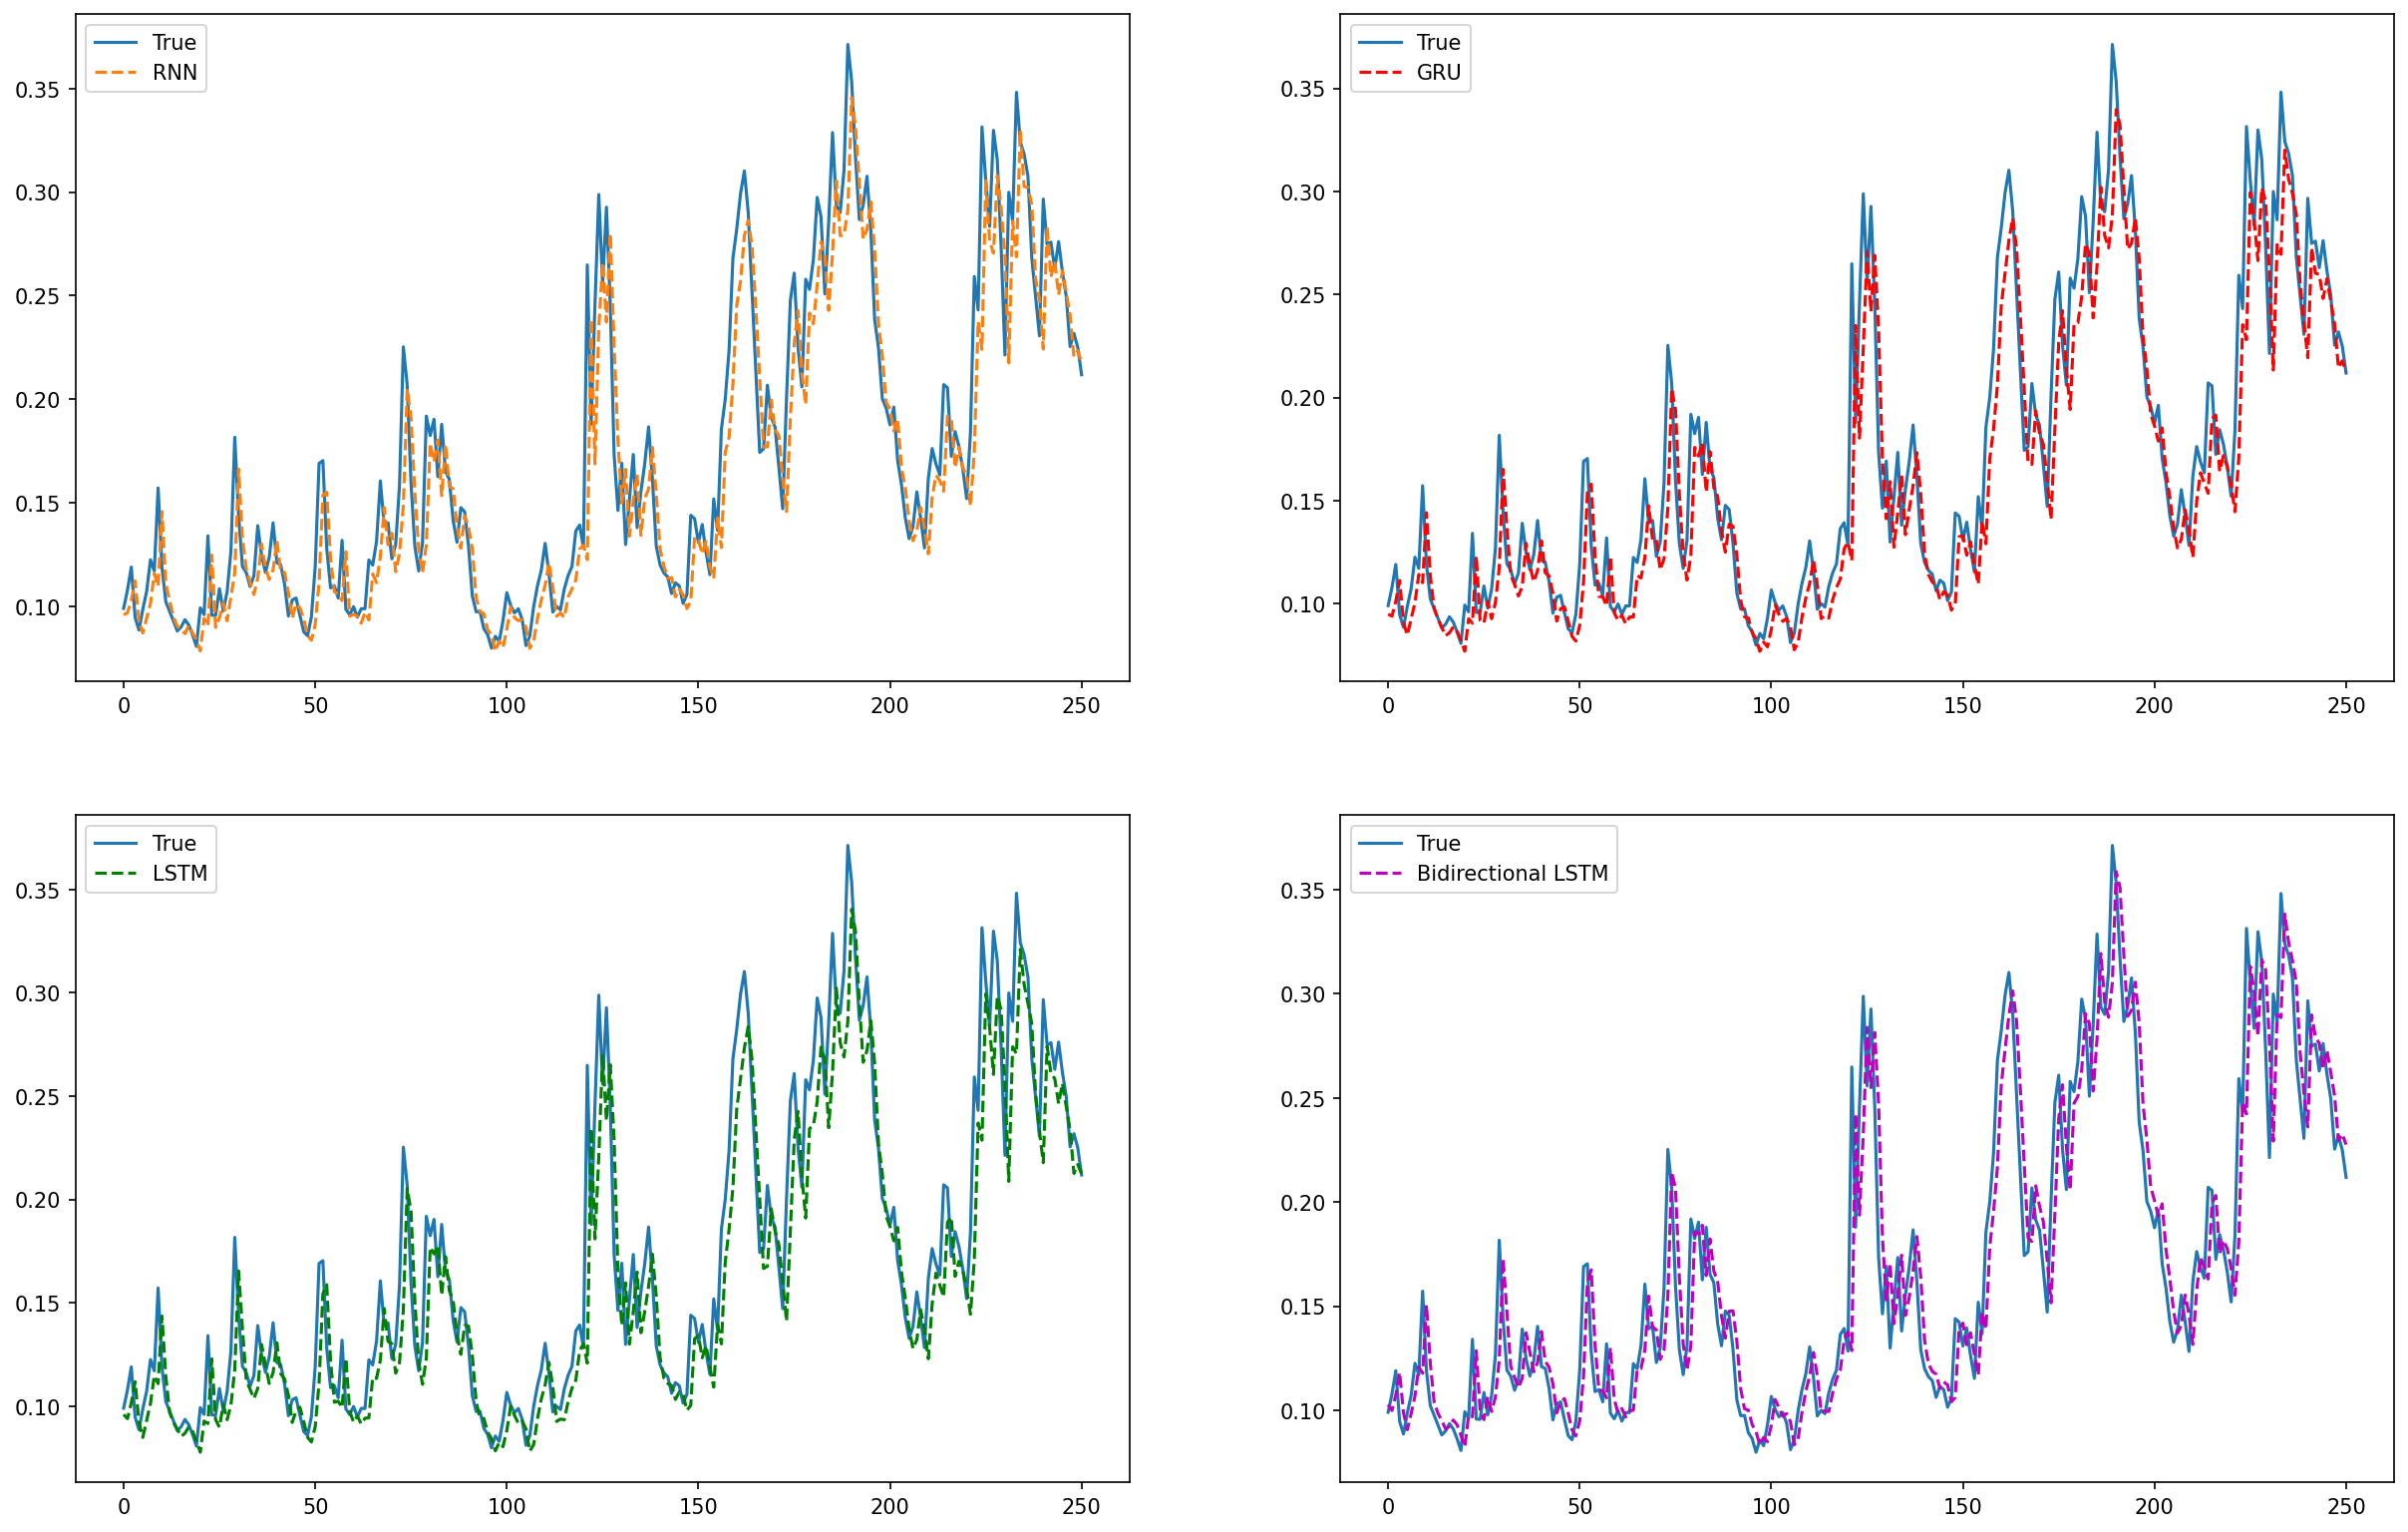

In [59]:
rnn_pred = rnn_model.predict(X_test)
rnn_mae = np.abs(np.subtract(y_test, rnn_pred)).mean()
rnn_mse = np.square(np.subtract(y_test, rnn_pred)).mean()
rnn_msle = np.square(np.subtract(np.log(y_test + 1), np.log(rnn_pred + 1))).mean()
rnn_mape = np.abs((y_test - rnn_pred) / y_test).mean() * 100
print(f" - RNN: \n\t mae = {rnn_mae:.5f}; mse = {rnn_mse:.5f}; msle = {rnn_msle:.5f}; mape = {rnn_mape:.5f}%")

gru_pred = gru_model.predict(X_test)
gru_mae = np.abs(np.subtract(y_test, gru_pred)).mean()
gru_mse = np.square(np.subtract(y_test, gru_pred)).mean()
gru_msle = np.square(np.subtract(np.log(y_test + 1), np.log(gru_pred + 1))).mean()
gru_mape = np.abs((y_test - gru_pred) / y_test).mean() * 100
print(f" - GRU: \n\t mae = {gru_mae:.5f}; mse = {gru_mse:.5f}; msle = {gru_msle:.5f}; mape = {gru_mape:.5f}%")

lstm_pred = lstm_model.predict(X_test)
lstm_mae = np.abs(np.subtract(y_test, lstm_pred)).mean()
lstm_mse = np.square(np.subtract(y_test, lstm_pred)).mean()
lstm_msle = np.square(np.subtract(np.log(y_test + 1), np.log(lstm_pred + 1))).mean()
lstm_mape = np.abs((y_test - lstm_pred) / y_test).mean() * 100
print(f" - LSTM: \n\t mae = {lstm_mae:.5f}; mse = {lstm_mse:.5f}; msle = {lstm_msle:.5f}; mape = {lstm_mape:.5f}%")

bidir_pred = bidir_model.predict(X_test)
bidir_mae = np.abs(np.subtract(y_test, bidir_pred)).mean()
bidir_mse = np.square(np.subtract(y_test, bidir_pred)).mean()
bidir_msle = np.square(np.subtract(np.log(y_test + 1), np.log(bidir_pred + 1))).mean()
bidir_mape = np.abs((y_test - bidir_pred) / y_test).mean() * 100
print(f" - Bidirectional LSTM: \n\t mae = {bidir_mae:.5f}; mse = {bidir_mse:.5f}; msle = {bidir_msle:.5f}; mape = {bidir_mape:.5f}%")

fig, ax = plt.subplots(2, 2, figsize=(20, 13), dpi=150)

ax[0, 0].plot(y_test, label='True')
ax[0, 0].plot(rnn_pred, linestyle='--', label='RNN')
ax[0, 0].legend(loc=2)

ax[0, 1].plot(y_test, label='True')
ax[0, 1].plot(gru_pred, linestyle='--', color='r', label='GRU')
ax[0, 1].legend(loc=2)

ax[1, 0].plot(y_test, label='True')
ax[1, 0].plot(lstm_pred, linestyle='--', color='g', label='LSTM')
ax[1, 0].legend(loc=2)

ax[1, 1].plot(y_test, label='True')
ax[1, 1].plot(bidir_pred, linestyle='--', color='m', label='Bidirectional LSTM')
ax[1, 1].legend(loc=2)

plt.show()

### Error metrics

*Univariate:*

- RNN: 
	- mse = 0.001074650754406612; mae = 0.023033138734553867; mape = 12.91123152923138%
 - GRU: 
	- mse = 0.0007996564517214099; mae = 0.01919836468773903; mape = 10.721522533753063%
 - LSTM: 
	- mse = 0.000811033351244647; mae = 0.01918201674848624; mape = 10.663131522243265%
 - Bidirectional LSTM: 
	- mse = 0.000755576708226678; mae = 0.020408566937683045; mape = 11.719401281215514%

*Multivariate:*

 - RNN: 
	- mae = 0.02606; mse = 0.00120; msle = 0.00082; mape = 15.57855%
 - GRU: 
	- mae = 0.02097; mse = 0.00080; msle = 0.00055; mape = 12.74910%
 - LSTM: 
	- mae = 0.02211; mse = 0.00087; msle = 0.00059; mape = 12.83362%
 - Bidirectional LSTM: 
	- mae = 0.02302; mse = 0.00090; msle = 0.00062; mape = 13.66875%